In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import networkx as nx
import seaborn as sns
import pickle

In [79]:
#임상데이터를 불러와서, 첫번째 열 제거하고, bcr_patient_barcode를 인덱스로 설정한다.

df_clinic = pd.read_csv('/home/lee/home/clinic_patient/LUAD_clinic_patient.csv')
df_clinic= df_clinic.iloc[:,1:]
df_clinic.set_index('bcr_patient_barcode', inplace=True)
df_clinic

,additional_studies,tumor_tissue_site,histological_type,other_dx,gender,vital_status,days_to_birth,days_to_last_known_alive,days_to_death,days_to_last_followup,...,stage_event_system_version,stage_event_clinical_stage,stage_event_pathologic_stage,stage_event_tnm_categories,stage_event_psa,stage_event_gleason_grading,stage_event_ann_arbor,stage_event_serum_markers,stage_event_igcccg_stage,stage_event_masaoka_stage
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244,NaN,Lung,Lung Adenocarcinoma- Not Otherwise Specified (...,No,MALE,NaN,-25752.0,NaN,NaN,NaN,...,6th,NaN,Stage IV,T2N2M1,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-05-4245,NaN,Lung,Lung Adenocarcinoma- Not Otherwise Specified (...,Yes,MALE,Alive,-29647.0,NaN,NaN,730.0,...,6th,NaN,Stage IIIA,T2N2M0,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-05-4249,NaN,Lung,Lung Adenocarcinoma- Not Otherwise Specified (...,No,MALE,Alive,-24532.0,NaN,NaN,1523.0,...,6th,NaN,Stage IB,T2N0M0,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-05-4250,NaN,Lung,Lung Adenocarcinoma- Not Otherwise Specified (...,No,FEMALE,NaN,-29068.0,NaN,121.0,NaN,...,6th,NaN,Stage IIIA,T3N1M0,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-05-4382,NaN,Lung,Lung Adenocarcinoma Mixed Subtype,Yes,MALE,Alive,-24868.0,NaN,NaN,607.0,...,6th,NaN,Stage IB,T2N0M0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-NJ-A55O,NaN,Lung,Mucinous (Colloid) Carcinoma,No,FEMALE,Alive,-20628.0,NaN,NaN,13.0,...,7th,NaN,Stage IIA,T1bN1M0,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-NJ-A55R,NaN,Lung,Lung Adenocarcinoma- Not Otherwise Specified (...,No,MALE,Alive,-24738.0,NaN,NaN,603.0,...,7th,NaN,Stage IA,T1bN0MX,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-NJ-A7XG,NaN,Lung,Lung Adenocarcinoma- Not Otherwise Specified (...,No,MALE,Alive,-18127.0,NaN,NaN,617.0,...,7th,NaN,Stage IIIA,T4N1M0,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
#분석하고자 하는 컬럼만 남긴다.
df_clinic = df_clinic[['icd_o_3_histology','icd_10','histological_type','kras_mutation_result',
'egfr_mutation_result','kras_mutation_found']]


df_clinic.head(5)

,icd_o_3_histology,icd_10,histological_type,kras_mutation_result,egfr_mutation_result,kras_mutation_found
bcr_patient_barcode,,,,,,
TCGA-05-4244,8140/3,C34.3,Lung Adenocarcinoma- Not Otherwise Specified (...,NaN,NaN,NaN
TCGA-05-4245,8140/3,C34.1,Lung Adenocarcinoma- Not Otherwise Specified (...,NaN,NaN,NaN
TCGA-05-4249,8140/3,C34.3,Lung Adenocarcinoma- Not Otherwise Specified (...,NaN,NaN,NaN
TCGA-05-4250,8140/3,C34.3,Lung Adenocarcinoma- Not Otherwise Specified (...,NaN,NaN,NaN
TCGA-05-4382,8255/3,C34.1,Lung Adenocarcinoma Mixed Subtype,NaN,NaN,NaN


In [81]:
print('사용한 서브타입 : ')
for i in df_clinic.columns:
    print(i)

사용한 서브타입 : 
icd_o_3_histology
icd_10
histological_type
kras_mutation_result
egfr_mutation_result
kras_mutation_found


In [82]:
#데이터프레임의 각 행을 입력받아 특정 값을 제외한 나머지 값을 dict형태로 변환한다.
# 함수는 row의 각 컬럼과 값을 순회하며 값이 NaN이 아니고 excluded_values 리스트에 없는 경우에만 col: val 쌍으로 포함한다.
def row_to_dict(row):
    excluded_values = [
        'Lung Adenocarcinoma- Not Otherwise Specified (NOS)',
        'Lung Adenocarcinoma Mixed Subtype',
        '8140/3',
        '8255/3',
        'C34.30',
        'C34.9',
        'Other',
        'nan'
          ]
    return {col: val for col, val in row.items() if pd.notna(val) and val not in excluded_values}

# 위 함수실행
row_sets = df_clinic.apply(row_to_dict, axis=1)

# 샘플 : {'컬럼이름': '값', '컬럼이름': '값', ... }
for index, value in row_sets.items():
    print(f'{index}: {value}')

TCGA-05-4244: {'icd_10': 'C34.3'}
TCGA-05-4245: {'icd_10': 'C34.1'}
TCGA-05-4249: {'icd_10': 'C34.3'}
TCGA-05-4250: {'icd_10': 'C34.3'}
TCGA-05-4382: {'icd_10': 'C34.1'}
TCGA-05-4384: {'icd_10': 'C34.3'}
TCGA-05-4389: {'icd_10': 'C34.1'}
TCGA-05-4390: {'icd_10': 'C34.1'}
TCGA-05-4395: {'icd_10': 'C34.1'}
TCGA-05-4396: {'icd_10': 'C34.3'}
TCGA-05-4397: {'icd_10': 'C34.2'}
TCGA-05-4398: {'icd_10': 'C34.1'}
TCGA-05-4402: {'icd_10': 'C34.3'}
TCGA-05-4403: {'icd_10': 'C34.1'}
TCGA-05-4405: {'icd_10': 'C34.3'}
TCGA-05-4410: {'icd_10': 'C34.1'}
TCGA-05-4415: {'icd_10': 'C34.3'}
TCGA-05-4417: {'icd_10': 'C34.1'}
TCGA-05-4418: {'icd_10': 'C34.3'}
TCGA-05-4420: {'icd_10': 'C34.3'}
TCGA-05-4422: {'icd_10': 'C34.3'}
TCGA-05-4424: {'icd_10': 'C34.1'}
TCGA-05-4425: {'icd_10': 'C34.2'}
TCGA-05-4426: {'icd_10': 'C34.3'}
TCGA-05-4427: {'icd_10': 'C34.1'}
TCGA-05-4430: {'icd_10': 'C34.3'}
TCGA-05-4432: {'icd_10': 'C34.1'}
TCGA-05-4433: {'icd_10': 'C34.3'}
TCGA-05-4434: {'icd_10': 'C34.3'}
TCGA-05-5420: 

In [84]:
no_matches = [] # 일치하는 항목이 두개 미만인 샘플 쌍 저장하는 리스트
matching_sametype_pairs = [] # 두 개 이상의 일치 항목을 가진 샘플 쌍을 별도로 저장함 (나중에 비교위해)

# 각샘플끼리 모두 비교
for (i1, row1), (i2, row2) in combinations(row_sets.items(), 2):
   
    common_items = set(row1.items()) & set(row2.items())
    
    
    num_matches = len(common_items)
    
    if num_matches >= 2:
        common_values = {k: v for k, v in common_items}
        matching_sametype_pairs.append((i1, i2))
    elif num_matches ==0:
        no_matches.append((i1, i2))

In [85]:
print("2개이상 (같은 서브타입) :", len(matching_sametype_pairs))
print("2개미만 (다른 서브타입) :",len(no_matches))

2개이상 (같은 서브타입) : 1247
2개미만 (다른 서브타입) : 71613


In [86]:
# 피클에서 불러와서 네트워크 만들고 확인
with open('/home/lee/home/pizzz&pkl/use_pkl/pcc0.3_sil0.4_th0.1_pvalue0.05_LUAD.pkl', 'rb') as f:
    results = pickle.load(f)

print("Results loaded from clustering_results.pkl")

# 불러온 results를 사용하여 네트워크 구축 
G = nx.Graph()
for combo, result in results:
    if result is not None:
        for sample in result:
            # 샘플 이름을 12글자로 자름 (클리닉과 비교하기 위함)
            trimmed_samples = [s[:12] for s in sample[1]] 
            G.add_edge(combo[0], combo[1], sample=trimmed_samples)


#자카드를 구하기 위해 각 샘플별 네트워크에서 어떤 gene을 갖고있는지를 나눔
sample_to_genes = {}
for u, v, data in G.edges(data=True):
    for sample in data['sample']:
        if sample not in sample_to_genes:
            sample_to_genes[sample] = set()
        sample_to_genes[sample].add(u)
        sample_to_genes[sample].add(v)

Results loaded from clustering_results.pkl


In [87]:
# 자카드 계수 계산 함수
def jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# 자카드 계수 계산
sametype_jaccard = []
for pair in matching_sametype_pairs:
    try:
        set1 = sample_to_genes[pair[0]]
        set2 = sample_to_genes[pair[1]]
        jaccard = jaccard_index(set1, set2)
        sametype_jaccard.append(jaccard)
    except KeyError as e:#이거는 clinic에서는 있는 쌍인데, 우리가 구축한 네트워크엔 그 쌍이 없어서 출력되는 예외처리
        print(f"KeyError for pair {pair}: {e}") 

differenttype_jaccard = []
for pair in no_matches:
    try:
        set1 = sample_to_genes[pair[0]]
        set2 = sample_to_genes[pair[1]]
        jaccard = jaccard_index(set1, set2)
        differenttype_jaccard.append(jaccard)
    except KeyError as e:
        print(f"KeyError for pair {pair}: {e}")

KeyError for pair ('TCGA-05-4244', 'TCGA-05-4245'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4244', 'TCGA-44-6144'): 'TCGA-44-6144'
KeyError for pair ('TCGA-05-4244', 'TCGA-44-A47F'): 'TCGA-44-A47F'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4249'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4250'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4384'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4396'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4397'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4402'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4405'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4415'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4418'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4420'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4422'): 'TCGA-05-4245'
KeyError for pair ('TCGA-05-4245', 'TCGA-05-4425'): 'TCGA-05-4

In [88]:
print("같은 서브타입 개수 :", len(sametype_jaccard))
print("다른 서브타입 개수 :",len(differenttype_jaccard))

같은 서브타입 개수 : 1247
다른 서브타입 개수 : 69936


In [89]:
import random

random.seed(42) 

#개수를 맞추기 위해 471863개에서 66696개만 랜덤으로 뽑았음
differenttype_jaccard = random.sample(differenttype_jaccard, min(1247, len(differenttype_jaccard)))


print("같은 네트워크 개수 :", len(sametype_jaccard))
print("다른 네트워크 개수 :",len(differenttype_jaccard))

같은 네트워크 개수 : 1247
다른 네트워크 개수 : 1247


In [91]:
import scipy.stats as stats

# 정규성 검정
stat1, p_value1 = stats.shapiro(sametype_jaccard)
stat2, p_value2 = stats.shapiro(differenttype_jaccard)

print("Shapiro-Wilk Test:")
print(f"sametype_jaccard - Statistic: {stat1:.3f}, P-value: {p_value1:.3f}")
print(f"differenttype_jaccard - Statistic: {stat2:.3f}, P-value: {p_value2:.3f}")

print('\n')


# wilcoxon's Test 수행
stat, p_value = stats.wilcoxon(sametype_jaccard, differenttype_jaccard)

print("wilcoxon Test:")
print(f"Statistic: {stat:.3f}")
print(f"P-value: {p_value:.3f}")  # 이때 0.05 미만이면 분산이 동일하지 않음을 의미한다.

print('\n')


Shapiro-Wilk Test:
sametype_jaccard - Statistic: 0.991, P-value: 0.000
differenttype_jaccard - Statistic: 0.988, P-value: 0.000


wilcoxon Test:
Statistic: 347071.000
P-value: 0.001




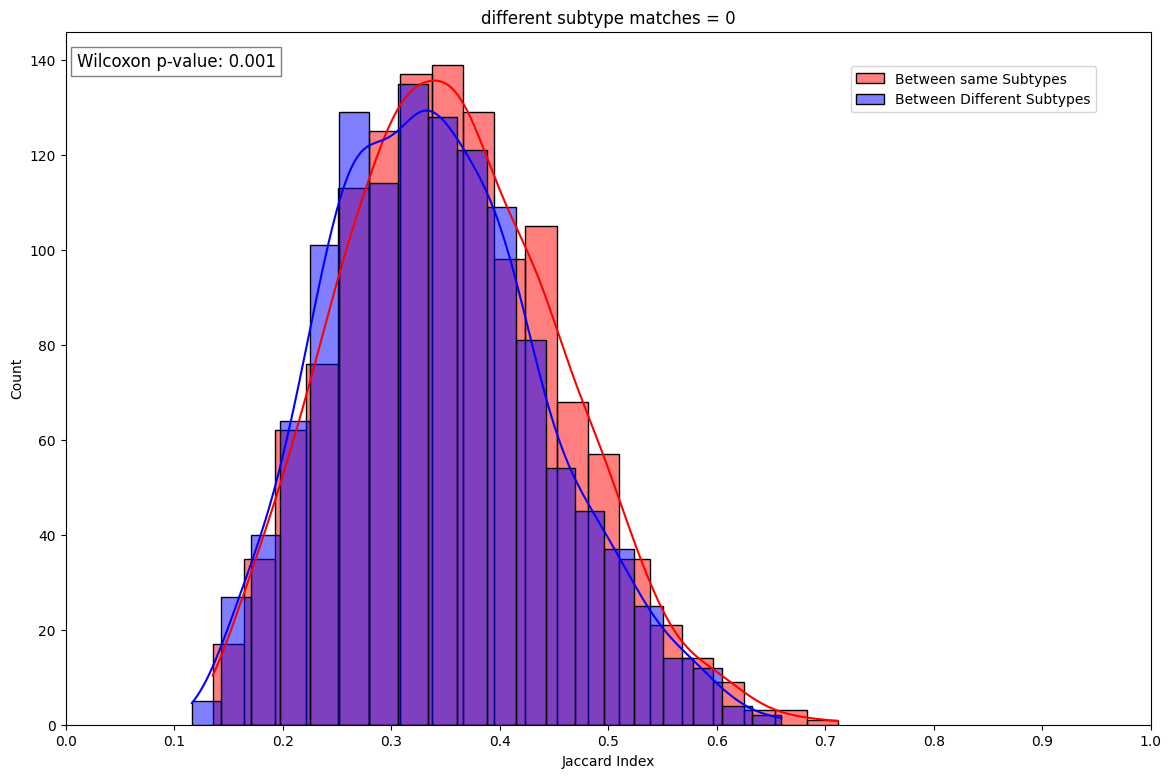

In [93]:
# 그래프 크기 설정
plt.figure(figsize=(14, 9))

# 서로 다른 서브타입 간 자카드 인덱스 히스토그램 추가
sns.histplot(sametype_jaccard, bins=20, kde=True, color='red', label='Between same Subtypes')
sns.histplot(differenttype_jaccard, bins=20, kde=True, color='blue', label='Between Different Subtypes')

# 0.5 축에 세로선 추가
#plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2)

plt.xlim(0.1, 0.9)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.title('different subtype matches = 0')
plt.xlabel('Jaccard Index')
plt.ylabel('Count')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

# 범례를 그래프 안으로 이동
plt.legend( loc='upper right', bbox_to_anchor=(0.95, 0.95), borderaxespad=0.)
# p-value 텍스트 추가
p_value_text = f'Wilcoxon p-value: {p_value:.3f}'
plt.text(0.01, max(plt.gca().get_ylim())*0.95, p_value_text, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

In [77]:

# 데이터를 딕셔너리로 구성
data_to_save = {
    "sametype_jaccard": sametype_jaccard,
    "differenttype_jaccard": differenttype_jaccard
}

# 피클 파일로 저장
with open('LUAD_jaccard_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)